In [1]:
!pip install pandas prophet matplotlib


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
import matplotlib.pyplot as plt


# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path, parse_dates=True, index_col=0)

def scale_non_date_columns(df):
    print(df.info())
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    if numeric_cols.empty:
        return df, None

    df_scaled = pd.DataFrame(index=df.index)

    scaler = StandardScaler()

    # Iterate through each column
    for column in df.columns:
        if df[column].dtype in ['float64', 'int64']:
            # Scale column
            scaled_column = scaler.fit_transform(df[[column]])
            df_scaled[column] = scaled_column.flatten()  # Add scaled column to df_scaled
        else:
            # Keep column
            df_scaled[column] = df[column]

    return df_scaled, scaler

# Transformer to rename datetime column
import re

class RenameDatetimeColumn(BaseEstimator, TransformerMixin):
    def detect_datetime_column(self, column_name):
        patterns = [
            r'\bdate\b',          # contains 'date'
            r'\bdatetime\b',      # contains 'datetime'
            r'\btimestamp\b',     # contains 'timestamp'
            r'\byear\b',          # contains 'year'
            r'\bmonth\b',         # contains 'month'
            r'\bday\b'            # contains 'day'
        ]
        return any(re.search(pattern, column_name.lower()) for pattern in patterns)

    def convert_to_datetime(self, series, expected_format):
        # Try expected format first
        series_converted = pd.to_datetime(series, errors='coerce', format=expected_format)
        if series_converted.isna().all():
            # If expected format fails, try without format
            series_converted = pd.to_datetime(series, errors='coerce')
            if series_converted.isna().all():
                # If both fail, try 'dd/mm/yyyy' format
                series_converted = pd.to_datetime(series, errors='coerce', format='%d/%m/%Y')
        return series_converted

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Check if the index contains datetime information
        if X.index.name and self.detect_datetime_column(X.index.name):
            try:
                X.index = self.convert_to_datetime(X.index, expected_format='%Y-%m-%d')
                X.index.names = ['Date']
                print(f"Renamed index to 'Date' and converted to datetime format.")
            except ValueError:
                print(f"Failed to convert index to datetime.")
        else:
            # Check each column for datetime patterns and attempt conversion
            for col in X.columns:
                if self.detect_datetime_column(col):
                    try:
                        X[col] = self.convert_to_datetime(X[col], expected_format='%Y-%m-%d')
                        X.rename(columns={col: 'Date'}, inplace=True)
                        print(f"Renamed '{col}' column to 'Date' and converted to datetime format.")
                        return X  # Return immediately after renaming first datetime column
                    except ValueError:
                        print(f"Failed to convert column '{col}' to datetime.")

            # Convert object columns to datetime
            for col in X.select_dtypes(include=['object']):
                try:
                    X[col] = self.convert_to_datetime(X[col], expected_format='%Y-%m-%d')
                except ValueError:
                    pass

            # Identify datetime columns after conversion
            date_columns = X.select_dtypes(include=['datetime64']).columns
            if not date_columns.empty:
                original_name = date_columns[0]
                X.rename(columns={original_name: 'Date'}, inplace=True)
                print(f"Renamed '{original_name}' column to 'Date' and converted to datetime format.")
            else:
                print("No datetime columns found.")

        return X

# Transformer to impute missing values
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in X.select_dtypes(include=['object']):
            try:
                X[col] = pd.to_datetime(X[col], errors='coerce')
            except ValueError:
                pass

        X.fillna(X.mean(), inplace=True)
        return X

# Transformer to scale non-date columns
class ScaleNonDateColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.numeric_cols = None

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
        if not self.numeric_cols.empty:
            self.scaler.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        for col in X.columns:
            if col in self.numeric_cols:
                X_scaled[col] = self.scaler.transform(X[[col]])
        return X_scaled

# Preprocessing pipeline
def preprocess_data_pipeline(file_path, Y_variable,scale):
    # Load data
    df = load_data(file_path)

    # Instantiate transformers
    rename_datetime = RenameDatetimeColumn()
    impute_missing = ImputeMissingValues()
    scale_non_date = ScaleNonDateColumns()

    # Pipeline definition
    pipeline = Pipeline([
        ('rename_datetime', rename_datetime),
        ('impute_missing', impute_missing)
    ])

    # Fit-transform the pipeline
    df_preprocessed = pipeline.fit_transform(df)

    # Ensure target variable exists
    if Y_variable not in df_preprocessed.columns:
        raise ValueError(f"Target variable '{Y_variable}' not found in the dataset.")

    # Separate X and Y
    X = df_preprocessed.drop(columns=[Y_variable])
    y = df_preprocessed[Y_variable]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if(scale):
      # Scale X data
      X_train_scaled, scaler_X = scale_non_date_columns(X_train)
      if scaler_X is None:
          print("Not scaling")
          X_test_scaled = X_test
          X_train_scaled = X_train
      else:
          X_test_scaled, scaler_X = scale_non_date_columns(X_test)
          X_train_scaled, scaler_X = scale_non_date_columns(X_train)

      # Scale y data
      scaler_y = StandardScaler()
      y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
      y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
    else:
      X_test_scaled = X_test
      X_train_scaled = X_train
      y_train_scaled = y_train
      y_test_scaled = y_test

    # Prophet model fitting and evaluation
    model = Prophet()
    if X_train_scaled.index.name == 'Date':
        train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
        test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
    else:
        train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
        test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

    #Model fitting
    model.fit(train_df_scaled.rename(columns={'Date': 'ds', Y_variable: 'y'}))

    #Predicting
    future = model.make_future_dataframe(periods=len(X_test))
    forecast = model.predict(future)


    y_pred = forecast['yhat'].iloc[-len(X_test):].values

    #Imputing nan values in y_pred
    if np.isnan(y_pred).any():
        y_pred = pd.Series(y_pred).fillna(y_pred.mean()).values
    mape = mean_absolute_percentage_error(y_test_scaled,y_pred)

    print("Mape : ",mean_absolute_percentage_error(y_test_scaled,y_pred),"%")
    model.plot(forecast)
    plt.title('Forecasting')
    plt.xlabel('Date')
    plt.ylabel(Y_variable)
    plt.show()


    return X_train, X_test, y_train, y_test


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/r72uuph2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/6gjviriw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95021', 'data', 'file=/tmp/tmp69btnyeg/r72uuph2.json', 'init=/tmp/tmp69btnyeg/6gjviriw.json', 'output', 'file=/tmp/tmp69btnyeg/prophet_modelb2xcbel6/prophet_model-20240711121731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Renamed index to 'Date' and converted to datetime format.


12:17:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mape :  0.25371273140011513 %


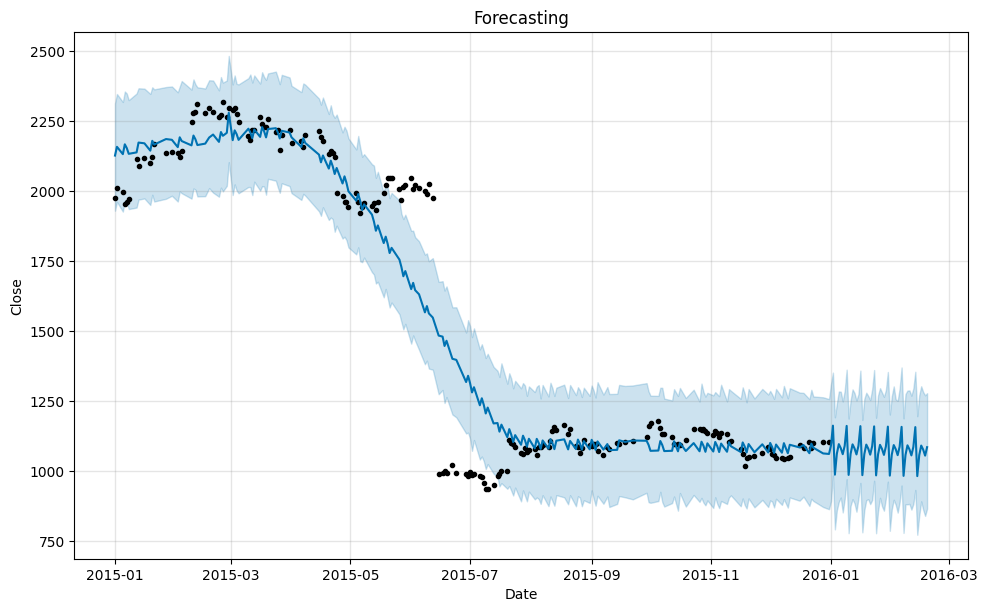

Train dataset shape after scaling: (198, 2)
Test dataset shape after scaling: (50, 2)

Scaled Training dataset preview:
                 Date    Close
Date                          
2015-08-14 2015-08-14  1149.25
2015-11-09 2015-11-09  1134.60
2015-06-24 2015-06-24   995.10
2015-10-15 2015-10-15  1097.35
2015-11-16 2015-11-16  1080.20


In [5]:
# Usage example
file_path = 'infy_stock.csv'
Y_variable = 'Close'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = preprocess_data_pipeline(file_path, Y_variable,False)

if X_train_scaled.index.name == 'Date':
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
print("\nScaled Training dataset preview:")
print(train_df_scaled.head())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/tq93hroz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/waehvko2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59663', 'data', 'file=/tmp/tmp69btnyeg/tq93hroz.json', 'init=/tmp/tmp69btnyeg/waehvko2.json', 'output', 'file=/tmp/tmp69btnyeg/prophet_modeldav11_aw/prophet_model-20240711121746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Renamed 'date' column to 'Date' and converted to datetime format.


12:17:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mape :  0.4236168099910482 %


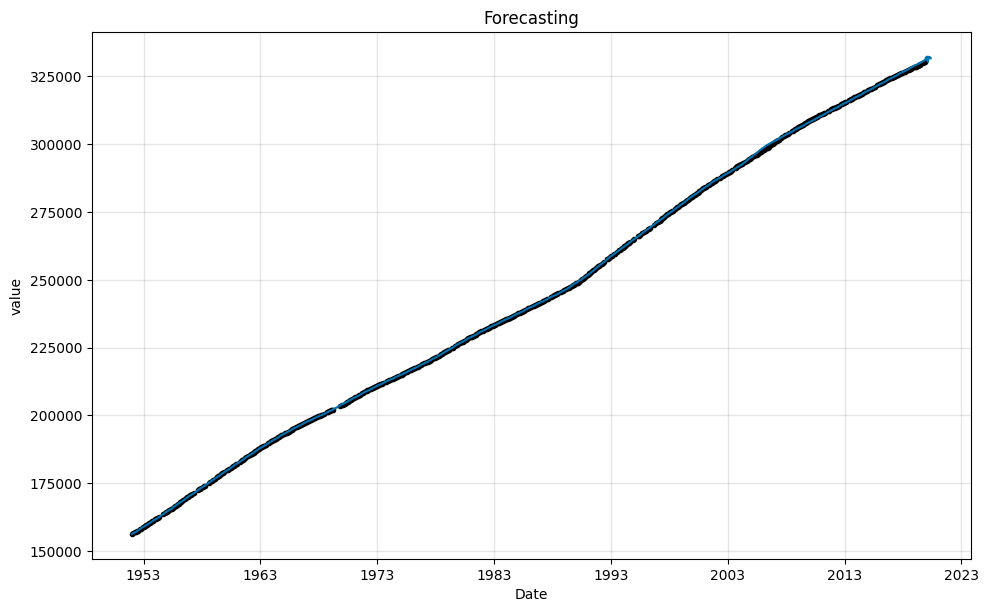

Train dataset shape after scaling: (652, 2)
Test dataset shape after scaling: (164, 2)

Scaled Training dataset preview:
                     Date     value
realtime_start                     
2019-12-06     1989-05-01  246906.0
2019-12-06     1979-12-01  226243.0
2019-12-06     1976-07-01  218035.0
2019-12-06     2009-01-01  306208.0
2019-12-06     1958-08-01  175143.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 652 entries, 2019-12-06 to 2019-12-06
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    652 non-null    datetime64[ns]
 1   value   652 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.3 KB
None


In [6]:
file_path = 'POP.csv'
Y_variable = 'value'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = preprocess_data_pipeline(file_path, Y_variable,False)

if(X_train_scaled.index.name == 'Date'):
  train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
  test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
  train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
  test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
print("\nScaled Training dataset preview:")
print(train_df_scaled.head())
print(train_df_scaled.info())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/rj0by0pk.json


Renamed index to 'Date' and converted to datetime format.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/o2kfc_pk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13484', 'data', 'file=/tmp/tmp69btnyeg/rj0by0pk.json', 'init=/tmp/tmp69btnyeg/o2kfc_pk.json', 'output', 'file=/tmp/tmp69btnyeg/prophet_modeljkf0545l/prophet_model-20240711122615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:26:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mape :  0.5697320477895491 %


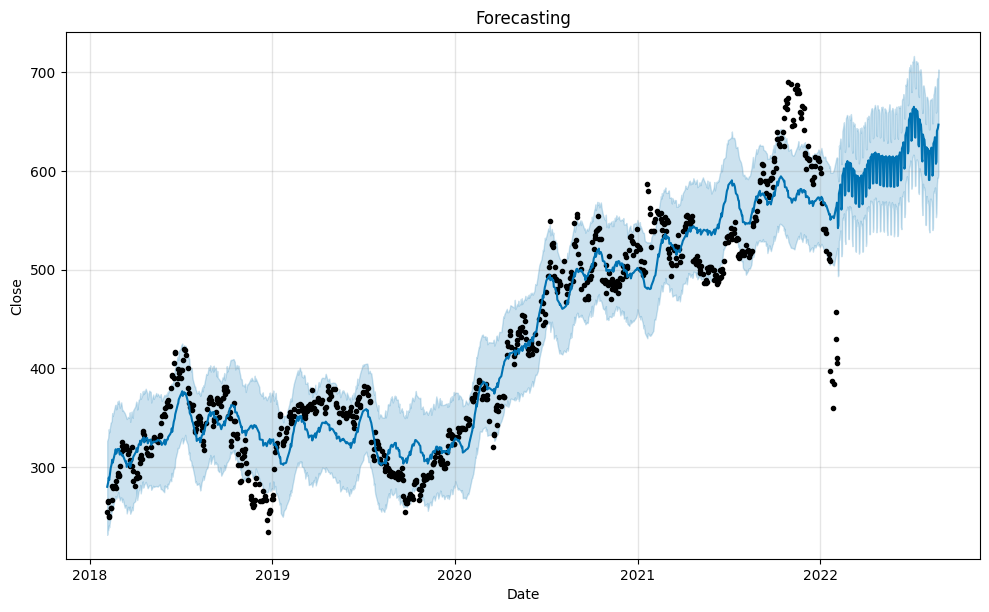

Train dataset shape after scaling: (807, 2)
Test dataset shape after scaling: (202, 2)

Scaled Training dataset preview:
                 Date       Close
Date                             
2018-03-19 2018-03-19  313.480011
2019-03-19 2019-03-19  358.779999
2020-02-11 2020-02-11  373.690002
2020-11-23 2020-11-23  476.619995
2021-07-30 2021-07-30  517.570007
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 807 entries, 2018-03-19 to 2018-07-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    807 non-null    datetime64[ns]
 1   Close   807 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.9 KB
None


In [7]:
file_path = 'NFLX.csv'
Y_variable = 'Close'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = preprocess_data_pipeline(file_path, Y_variable,False)

if(X_train_scaled.index.name == 'Date'):
  train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
  test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
  train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
  test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
print("\nScaled Training dataset preview:")
print(train_df_scaled.head())
print(train_df_scaled.info())

<ipython-input-2-f1f0ee1871e8>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(file_path, parse_dates=True, index_col=0)
<ipython-input-2-f1f0ee1871e8>:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series_converted = pd.to_datetime(series, errors='coerce')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/ayvg12wd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69btnyeg/cvdw6q_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/

Renamed 'TxnDate' column to 'Date' and converted to datetime format.


12:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mape :  27.513791761325024 %


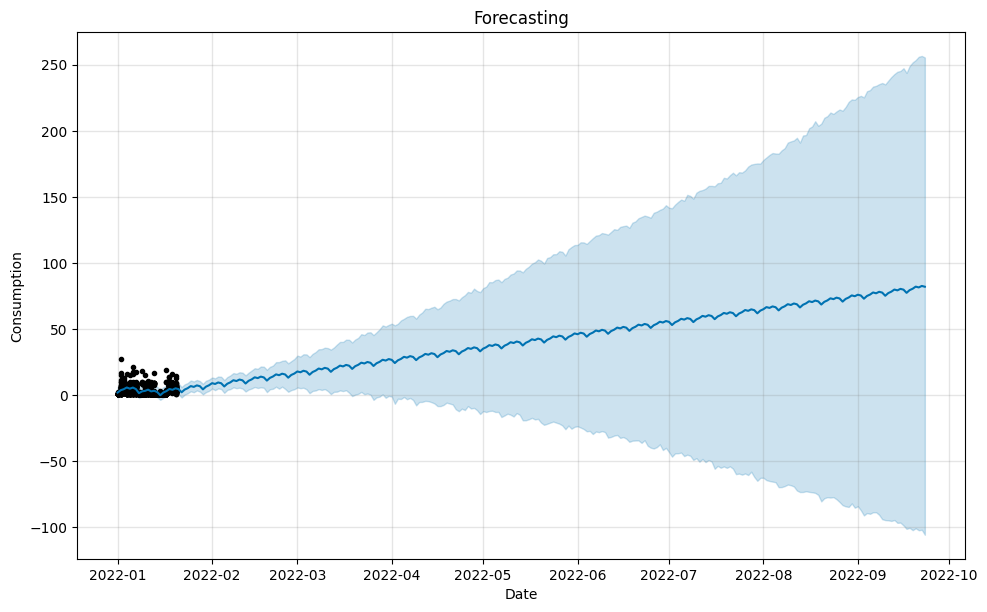

Train dataset shape after scaling: (982, 2)
Test dataset shape after scaling: (246, 2)

Scaled Training dataset preview:
            Date  Consumption
92952 2022-01-19        4.832
93027 2022-01-18        2.276
86307 2022-01-06        1.872
86933 2022-01-07        7.964
80273 2022-01-11        4.638


In [11]:
# Usage example
file_path = 'energy.csv'
Y_variable = 'Consumption'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = preprocess_data_pipeline(file_path, Y_variable,False)

if X_train_scaled.index.name == 'Date':
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
print("\nScaled Training dataset preview:")
print(train_df_scaled.head())